In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import PurePath
from huggingface_hub import snapshot_download
from sklearn.metrics import classification_report
import sys
import os
# Get the absolute path of the vim directory
vim_path = os.path.abspath('vim')
# Add the vim directory to the system path
sys.path.append(vim_path)

/home/eh_abdol/.conda/envs/vim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from vim.models_mamba import VisionMamba

In [3]:
# Function to get all image files from a directory


def get_image_files(folder):
    files = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                files.append(os.path.join(root, filename))
    return files

# Custom Dataset Class for Binary Classification


class CustomBinaryDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.data = []
        self.class_names = ['Full', 'Partial']  # Explicitly define class names
        self.load_images()

    def load_images(self):
        for class_name in self.class_names:
            class_folder = os.path.join(self.folder, class_name)
            if os.path.isdir(class_folder):
                class_index = self.class_names.index(
                    class_name)  # 0 for 'Full', 1 for 'Partial'
                image_files = get_image_files(class_folder)
                for image_file in image_files:
                    self.data.append({
                        'image': image_file,
                        'label': class_index,  # Binary label: 0 for 'Full', 1 for 'Partial'
                    })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]['image']
        label = self.data[idx]['label']

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


# Image transformations (Resizing and Normalizing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Folders
train_folder = '/home/eh_abdol/fine_tune/gold4/train'
validation_folder = '/home/eh_abdol/fine_tune/gold4/validation'
test_folder = '/home/eh_abdol/fine_tune/gold4/test'
# test_folder = '/media/data/eh_abdol/dataset/test'

# Create Datasets
train_dataset = CustomBinaryDataset(train_folder, transform=transform)
validation_dataset = CustomBinaryDataset(
    validation_folder, transform=transform)
test_dataset = CustomBinaryDataset(test_folder, transform=transform)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(
    validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Now you can use test_loader to evaluate the model after fine-tuning

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Dataset size: 797
Validation Dataset size: 254
Test Dataset size: 296


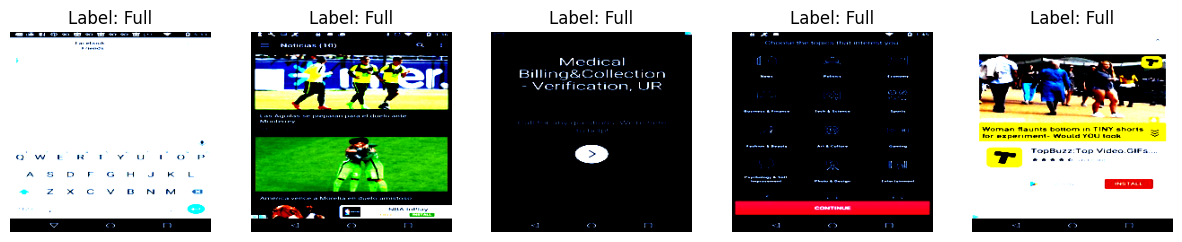

Batch size: 16
Image shape: torch.Size([16, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1])


In [4]:
# Function to display a few sample images with labels


def show_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        image, label = dataset[i]
        # Rearrange dimensions to HWC for plotting
        image = image.permute(1, 2, 0)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {dataset.class_names[label]}")
        axes[i].axis('off')
    plt.show()


# Print dataset lengths to ensure the size is correct
print(f"Train Dataset size: {len(train_dataset)}")
print(f"Validation Dataset size: {len(validation_dataset)}")
print(f"Test Dataset size: {len(test_dataset)}")

# Visualize a few samples from the training dataset
show_samples(train_dataset, num_samples=5)

# Check DataLoader output
for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}")
    print(f"Image shape: {images.size()}")
    print(f"Labels: {labels}")
    break  # Check the first batch only

In [4]:
# Load Vision Mamba architecture with modified output layer (2 classes)
model = VisionMamba(
    patch_size=16,
    stride=8,
    embed_dim=384,
    depth=24,
    rms_norm=True,
    residual_in_fp32=True,
    fused_add_norm=True,
    final_pool_type='mean',
    if_abs_pos_embed=True,
    if_rope=False,
    if_rope_residual=False,
    bimamba_type="v2",
    if_cls_token=True,
    if_devide_out=True,
    use_middle_cls_token=True,
    num_classes=2,  # Update for binary classification
    drop_rate=0.0,
    drop_path_rate=0.1,
    drop_block_rate=None,
    img_size=224,
)

In [5]:
# Download the pretrained weights from Hugging Face Hub
VIM_REPO = "hustvl/Vim-small-midclstok"
pretrained_model_dir = snapshot_download(
    repo_id=VIM_REPO, local_files_only=True)

# Load the pretrained weights
MODEL_FILE = PurePath(pretrained_model_dir, "vim_s_midclstok_ft_81p6acc.pth")
print(MODEL_FILE)

/home/eh_abdol/.cache/huggingface/hub/models--hustvl--Vim-small-midclstok/snapshots/babc4440f5fab6e08d97e371afa639c8cf98bf2c/vim_s_midclstok_ft_81p6acc.pth


In [6]:
# Load the checkpoint
checkpoint = torch.load(str(MODEL_FILE), map_location='cpu')

# Remove the 'head.weight' and 'head.bias' from the pretrained checkpoint
pretrained_dict = checkpoint['model']
pretrained_dict = {k: v for k, v in pretrained_dict.items()
                   if not k.startswith('head')}

# Load the pretrained weights (excluding the final classification layer)
model.load_state_dict(pretrained_dict, strict=False)

# Initialize a new classification head for binary classification (2 classes)
model.head = nn.Linear(in_features=384, out_features=2)

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionMamba(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (head): Linear(in_features=384, out_features=2, bias=True)
  (drop_path): DropPath()
  (layers): ModuleList(
    (0-1): 2 x Block(
      (mixer): Mamba(
        (in_proj): Linear(in_features=384, out_features=1536, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (x_proj): Linear(in_features=768, out_features=56, bias=False)
        (dt_proj): Linear(in_features=24, out_features=768, bias=True)
        (conv1d_b): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (x_proj_b): Linear(in_features=768, out_features=56, bias=False)
        (dt_proj_b): Linear(in_features=24, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=384, bias=False)
      )
      (norm): RM

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Freeze all layers except the final classification head
# for param in model.parameters():
#     param.requires_grad = False  # Lock all layers

# Unlock only the classification head for fine-tuning
# for param in model.head.parameters():
#     param.requires_grad = True  # Train the classification head

# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Use a smaller learning rate for fine-tuning
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# Create optimizer to only optimize the parameters that require gradients
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)  # 5e-6

# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer, step_size=3, gamma=0.1)  # Reduces learning rate every 3 epochs

Epoch [1/10], Loss: 0.7280, Train Accuracy: 51.57%, Validation Accuracy: 59.06%
Epoch [2/10], Loss: 0.6316, Train Accuracy: 64.49%, Validation Accuracy: 73.23%
Epoch [3/10], Loss: 0.5283, Train Accuracy: 74.28%, Validation Accuracy: 75.20%
Epoch [4/10], Loss: 0.4265, Train Accuracy: 81.43%, Validation Accuracy: 74.02%
Epoch [5/10], Loss: 0.3529, Train Accuracy: 84.82%, Validation Accuracy: 81.10%
Epoch [6/10], Loss: 0.2911, Train Accuracy: 87.83%, Validation Accuracy: 81.10%
Epoch [7/10], Loss: 0.2641, Train Accuracy: 89.08%, Validation Accuracy: 77.17%
Epoch [8/10], Loss: 0.1986, Train Accuracy: 91.84%, Validation Accuracy: 79.53%
Epoch [9/10], Loss: 0.1577, Train Accuracy: 93.22%, Validation Accuracy: 79.13%
Epoch [10/10], Loss: 0.1675, Train Accuracy: 92.72%, Validation Accuracy: 78.74%
Finished Training


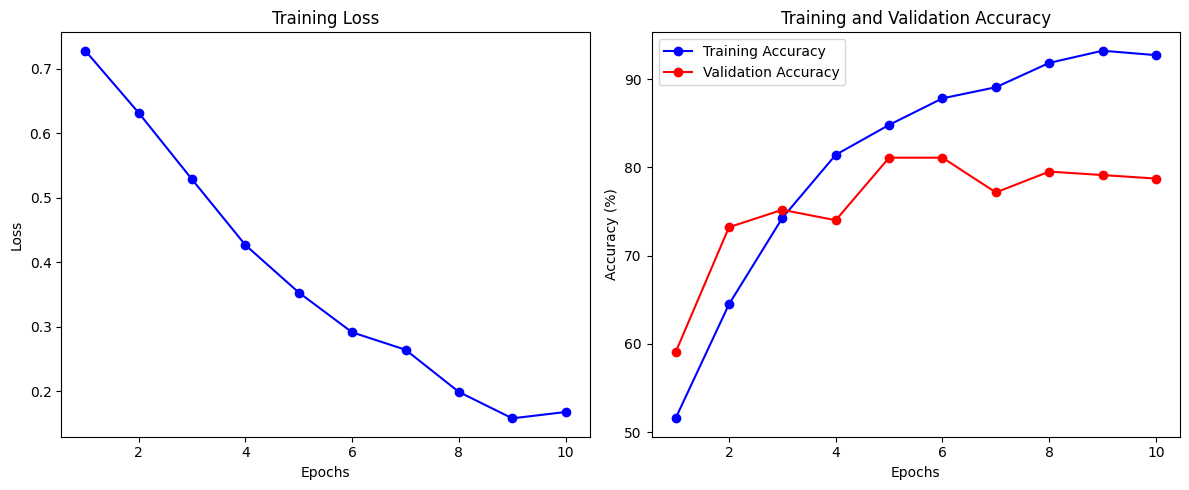

In [8]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)

    # Lists to store metrics for plotting
    train_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track accuracy and loss
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Validation after every epoch
        val_acc = validate_model(model, validation_loader, device)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        val_acc = validate_model(model, validation_loader, device)

        # Store metrics
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {100.*correct/total:.2f}%, Validation Accuracy: {val_acc:.2f}%")

    print('Finished Training')

    # Plot training curves
    plot_training_curves(train_losses, train_accs, val_accs)

    # Save the trained model's weights
    # torch.save(model.state_dict(), 'vision_mamba_finetuned.pth')
    # print("Model weights saved successfully.")


def validate_model(model, validation_loader, device='cuda'):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # disables gradient tracking during the validation process
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            # finds the index of the maximum value in each row of the output tensor,
            # which corresponds to the class prediction.
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total


def plot_training_curves(train_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()


# Fine-tune the model
train_model(model, train_loader, validation_loader,
            criterion, optimizer, num_epochs=10)

In [9]:
def test_model(model, test_loader, device='cuda'):
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    return accuracy


# Test the model
test_model(model, test_loader)  # Assuming 2 classes

Test Accuracy: 79.39%

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       163
           1       0.78      0.75      0.77       133

    accuracy                           0.79       296
   macro avg       0.79      0.79      0.79       296
weighted avg       0.79      0.79      0.79       296



79.39189189189189